In [2]:
import pandas as pd
import numpy as np
import seaborn as sb

import matplotlib.pyplot as plt

import os
import sys
import gc
import pickle
import pathlib

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential, load_model
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score

## OPEN PICKLE FILES AND MODELS

In [3]:
# Set classes
classes = ['Bacterial leaf blight', 'Brown spot', 'Leaf smut']

# Open pickle data
X_dataset = pickle.load(open('..\\DATASET\\whole_dataset_pickle\\X_dataset_3_classes.pickle', 'rb'))
y_dataset = pickle.load(open('..\\DATASET\\whole_dataset_pickle\\y_dataset_3_classes.pickle', 'rb'))
y_dataset = np.array(y_dataset)


# Splitting dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, test_size = 0.10, shuffle = True, 
                                                    random_state = 42)
print(y_train[:5])
print(y_test[:5])

[2 1 1 2 1]
[1 2 1 0 2]


In [9]:
# Loading the h5 file that contains the trained models
models = list()
model_names = list()
for index, model in enumerate(pathlib.Path('..\\SAVED MODELS (H5 Files)').iterdir()):
    if str(model).endswith('.h5'):
        print(f'Model {index}: {model}')
        models.append(load_model(model))
        model_names.append(str(model).split('\\')[2])


Model 0: ..\SAVED MODELS (H5 Files)\acnn_model_no_attention_50_one_whole_pickle.h5
Model 1: ..\SAVED MODELS (H5 Files)\acnn_model_no_attention_50_v1.1.h5
Model 2: ..\SAVED MODELS (H5 Files)\acnn_model_no_attention_50_v1.2.h5
Model 3: ..\SAVED MODELS (H5 Files)\acnn_model_no_attention_model.h5
Model 4: ..\SAVED MODELS (H5 Files)\acnn_model_no_attention_whole_pickle_lr_0000088.h5
Model 5: ..\SAVED MODELS (H5 Files)\acnn_model_no_attention_whole_pickle_lr_00001.h5


## SINGLE MODEL

In [17]:
# Select model from the previous list
acnn_model = models[5]

# Accuracy of the model based on the testing:
acnn_model.evaluate(X_test, y_test)
acnn_model.summary()

# Get the label predictions of acnn_model
y_pred = acnn_model.predict(X_test)
na_pred_classes = [np.argmax(element) for element in y_pred]

8/8 [==============================] - 2s 228ms/step - loss: 0.1681 - accuracy: 0.9722
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 56, 56, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 56, 56, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 27, 27, 256)      1024      
 hNormalization)                   

[Text(0, 0.5, 'BLF'), Text(0, 1.5, 'Brown spot'), Text(0, 2.5, 'Leaf smut')]

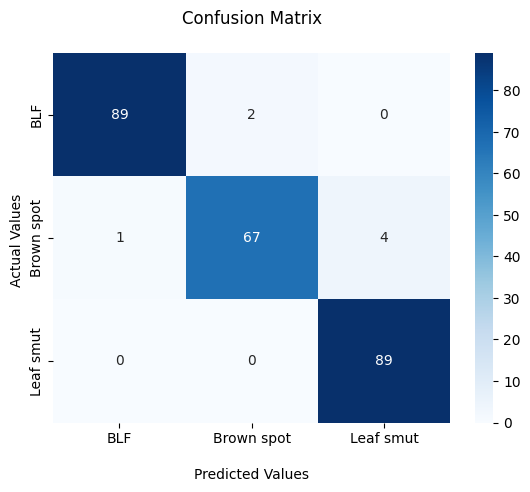

In [11]:
# Show the confusion matrix
classes_shortened = ["BLF", "Brown spot", "Leaf smut"]
conf_matrix = confusion_matrix(y_test, na_pred_classes)
ax = sb.heatmap(conf_matrix, annot=True, cmap='Blues')
ax.set_title('Confusion Matrix\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')
ax.xaxis.set_ticklabels(classes_shortened)
ax.yaxis.set_ticklabels(classes_shortened)

In [12]:
# Classification Report
print(f'''Classification Report:\n{classification_report(y_test,
    na_pred_classes, target_names=classes)}''')

# Display the error rate
accuracy = accuracy_score(y_test, na_pred_classes)
print('Error: %.3f' % ((1-accuracy) * 100) + '%')

Classification Report:
                       precision    recall  f1-score   support

Bacterial leaf blight       0.99      0.98      0.98        91
           Brown spot       0.97      0.93      0.95        72
            Leaf smut       0.96      1.00      0.98        89

             accuracy                           0.97       252
            macro avg       0.97      0.97      0.97       252
         weighted avg       0.97      0.97      0.97       252

Error: 2.778%


## MULTIPLE MODELS RESULTS

In [13]:
# Create predictions list
list_pred_classes = list()
list_acc = list()

# Select models from the model list
for index, acnn_model in enumerate(models):
    # Accuracy of the model based on the testing:
    acnn_model.evaluate(X_test, y_test)
    
    # Get the label predictions of acnn_model
    y_pred = acnn_model.predict(X_test)
    na_pred_classes = [np.argmax(element) for element in y_pred]
    list_pred_classes.append(na_pred_classes)

    # Classification Report
    print(f'''Classification Report [{model_names[index]}]:\n{classification_report(y_test,
        na_pred_classes, target_names=classes)}''')

    # Display the error rate
    accuracy = accuracy_score(y_test, na_pred_classes)
    list_acc.append(str((accuracy*100).round(2)) + '%')
    print('Error: %.3f' % ((1-accuracy) * 100) + '%')

8/8 [==============================] - 2s 237ms/step
Classification Report [acnn_model_no_attention_50_one_whole_pickle.h5]:
                       precision    recall  f1-score   support

Bacterial leaf blight       0.93      0.97      0.95        91
           Brown spot       0.99      0.94      0.96        72
            Leaf smut       0.95      0.94      0.95        89

             accuracy                           0.95       252
            macro avg       0.96      0.95      0.95       252
         weighted avg       0.95      0.95      0.95       252

Error: 4.762%
8/8 [==============================] - 2s 226ms/step
Classification Report [acnn_model_no_attention_50_v1.1.h5]:
                       precision    recall  f1-score   support

Bacterial leaf blight       0.64      0.85      0.73        91
           Brown spot       1.00      0.04      0.08        72
            Leaf smut       0.62      0.90      0.74        89

             accuracy                           0.

In [15]:
def confusion_matrix_heatmap(conf_matrix, names):  
    cx = [0, 1, 2, 3, 4, 5]
    fig, ((cx[0], cx[1], cx[2]), (cx[3], cx[4], cx[5])) = plt.subplots(nrows=2, ncols=3, figsize=(14, 8.5), layout='tight', dpi=80)

    for x in range(len(models)):
        cx[x] = sb.heatmap(conf_matrix[x], annot=True, cmap='Blues', ax=cx[x])
        cx[x].xaxis.set_ticklabels(classes_shortened)
        cx[x].yaxis.set_ticklabels(classes_shortened)
        cx[x].set(xlabel='Predicted label', ylabel='True label')
        cx[x].set_title(f'{names[x]} [{list_acc[x]}]', fontsize=10)

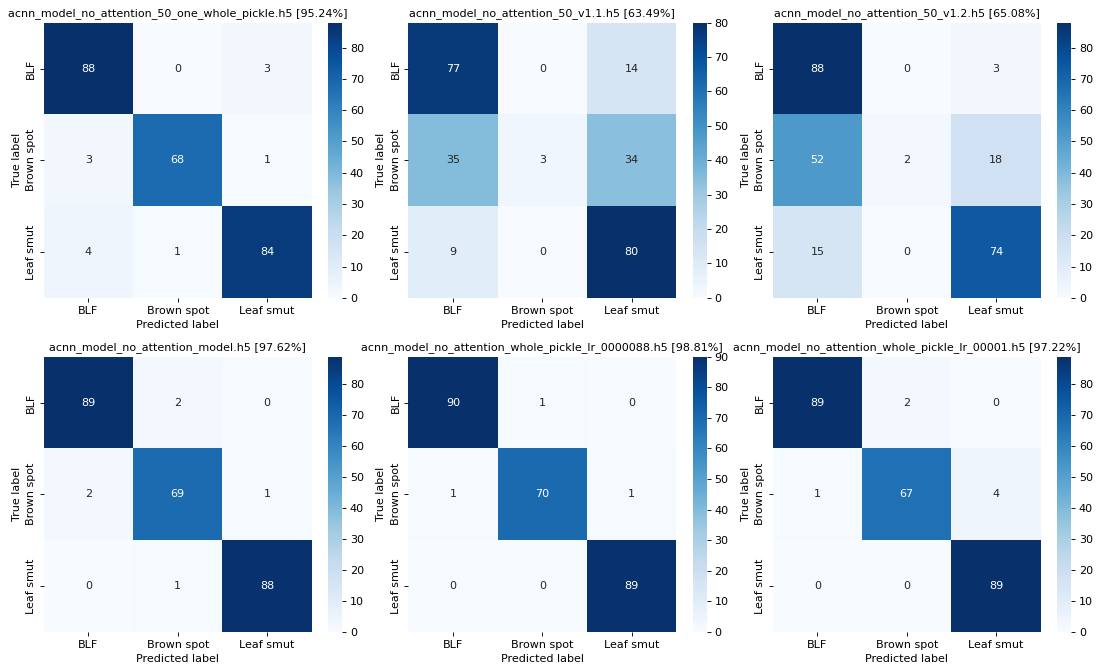

In [16]:
# Classifier Algorithms Confusion Matrix
conf_matrix = [[]] * len(models)

# Confusion Matrix
for x in range(len(models)):
    conf_matrix[x] = confusion_matrix(np.array(y_test), list_pred_classes[x])   
confusion_matrix_heatmap(conf_matrix=conf_matrix, names=model_names)